In [232]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions

%matplotlib inline

def linear_kernel(x1, x2,degree):
    return x1.T @ x2

def polynomial_kernel(x1,x2,degree):
    # print(f'x1.shape::{x1.shape}')
    # print(f'x2.shape{x2.shape}')
    return pow(x1 @ x2.T,degree)

class svm():
    def __init__(self, kernel='linear', degree = 3,c=1.0, tol=1e-3,eps = 0.001, maxiter=1000):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        self._degree = degree
        if self._kernel == 'linear':
            self._k = linear_kernel
        elif self._kernel == 'poly':
            self._k = polynomial_kernel
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        
        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            # print(f'data.shape:: {self._data.shape}')
            # print(f'target.shape:: {self._targets.shape}')
            for i in range(self._data.shape[0]):
                # print(f'target:: {self._targets[i].shape}')
                # print(f'alphas:: {self._alphas[i].shape}')
                # print(f'b:: {self._b}')
                # print(f'kernel:: {self._k(self._data[i], x,3)}')
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x,self._degree)
            u -= self._b

        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        # print('In predict')
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0
      
        k11 = self._k(x1, x1,self._degree)
        k22 = self._k(x2, x2,self._degree)
        k12 = self._k(x1, x2,self._degree)

        eta = k11 + k22 - 2 * k12
        a2 = 0
        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        # TODO: the negative case
        else:
            f1 = (y1 * (e1 + self._b)) - (alpha1 * k11) - (s * alpha2 * k12)
            f2 = (y2 * (e2 + self._b)) - (s * alpha1 * k11) - (alpha2 * k22)
            L1 = alpha1 + s * (alpha2 - L)
            H1 = alpha1 + s * (alpha2 - H)
            Lobj = (L1 * f1) + (L * f2) + (L1 * L1 * k11)/2 + (L * L * k22)/2 + (s * L * L1 * k12)
            Hobj = (H1 * f1) + (H * f2) + (H1 * H1 * k11)/2 + (H * H * k22)/2 + (s * H * H1 * k12)
            if Lobj < Hobj - 1e-3:
                a2 = L
            elif Lobj> Hobj + 1e-3:
                a2 = H
            else:
                a2 = alpha2
            print(f"[DEBUG] smo_step: eta = {eta}")
               
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)

        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point.
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                # Loop over all possible i1, starting at a random point
                for i in range(self._data.shape[0]):
                    if i == i2:
                        continue
                    if self.smo_step(i, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

In [233]:
n_a_samples = 50
n_b_samples = 50

a_samples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], n_a_samples)
b_samples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], n_b_samples)
a_targets = np.ones(n_a_samples) * -1  # Samples from class A are assigned a class value of -1.
b_targets = np.ones(n_b_samples)  # Samples from class B are assigned a class value of 1.

samples = np.concatenate((a_samples, b_samples))
targets = np.concatenate((a_targets, b_targets))
print(samples.shape, targets.shape)

(100, 2) (100,)


In [234]:
model = svm(c=5.0)
model.fit(samples, targets)
print(model._weights)
print(model._b)

[ 0.97657116 -0.86704661]
-0.37690469283295247


weights=[ 0.97657116 -0.86704661]
b=-0.37690469283295247


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


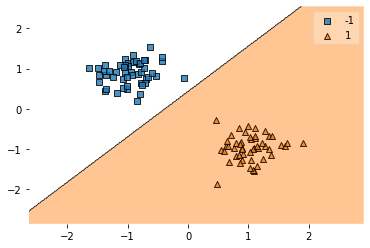

In [235]:
print(f"weights={model._weights}")
print(f"b={model._b}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), model)
fig.add_subplot(ax)
plt.show()

coef_=[[ 0.77293034 -0.80049862]]
intercept=[-0.04255239]


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


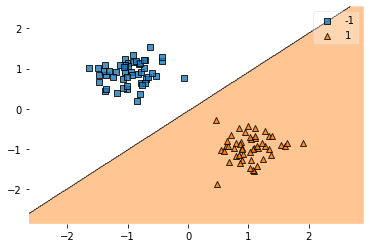

In [236]:
from sklearn.svm import LinearSVC
sk_model = LinearSVC()
sk_model.fit(samples, targets.astype(np.int32))

print(f"coef_={sk_model.coef_}")
print(f"intercept={sk_model.intercept_}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), sk_model)
fig.add_subplot(ax)
plt.show()

### **Task 2 Starts here**

In [237]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=3_00, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [238]:
np.unique(y)

array([0, 1])

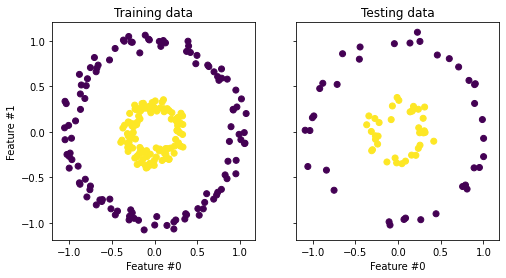

In [239]:
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

In [240]:
non_linear = svm(kernel='poly')

In [241]:
non_linear.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


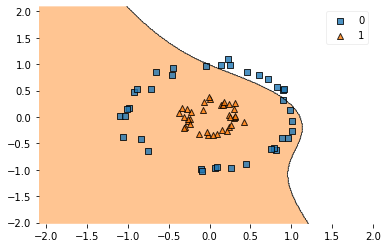

In [242]:
fig = plt.figure()
ax = plot_decision_regions(X_test, y_test.astype(np.int32), non_linear)
fig.add_subplot(ax)
plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


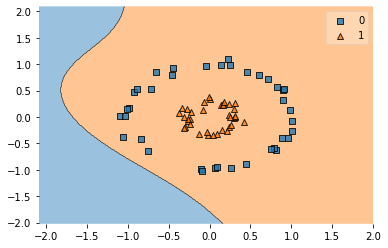

In [243]:
from sklearn.svm import SVC
clf = SVC(gamma="auto", kernel='poly')
clf.fit(X_train, y_train)
fig = plt.figure()
ax = plot_decision_regions(X_test, y_test.astype(np.int32), clf)
fig.add_subplot(ax)
plt.show()

### **Task 3 Starts here**

In [244]:
from sklearn import datasets
data = datasets.load_iris()
X = data.data
y = data.target

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
k = len(np.unique(y_train))


In [246]:
class MultiClass:
  def __init__(self,k,kernel='linear', degree = 3,c=1.0, tol=1e-3,eps = 0.001, maxiter=1000) -> None:
      self.k = k
      self.models = {}
      self.svc_model = SVC(gamma = 'auto',kernel = kernel)
      self.predicted = []
      for i in range(k):
          self.models[str(i)] = svm(kernel, degree,c, tol,eps, maxiter)
          
      
  def fit(self,X,y):
      self.svc_model.fit(X,y)
      for i in range(k):
          target = y.copy()
          target[target != i] = -1
          target[target == i] = 1
          self.models[str(i)].fit(X,target)
          
  def predict(self,X,y):
      svc_predicted = self.svc_model.predict(X)
      for i in range(k):
          target = y.copy()
          target[target != i] = -1
          target[target == i] = 1
          score = self.models[str(i)].predict_score(X)
          self.predicted.append(score)
      res = np.argmax(np.column_stack(self.predicted),axis = 1)
      m_accuracy = (res == y)
      svc_accuracy = (svc_predicted == y)
      print(f'Multiclass SVM implemented Model accuracy: {m_accuracy.sum()/m_accuracy.size}')
      print(f'Multiclass SVM sklearn Model accuracy: {svc_accuracy.sum()/svc_accuracy.size}')

In [247]:
linear = MultiClass(k,kernel = 'linear')
linear.fit(X_train,y_train)
linear.predict(X_test,y_test)

Multiclass SVM implemented Model accuracy: 0.6842105263157895
Multiclass SVM sklearn Model accuracy: 1.0


In [248]:
linear = MultiClass(k,kernel = 'poly')
linear.fit(X_train,y_train)
linear.predict(X_test,y_test)


Multiclass SVM implemented Model accuracy: 1.0
Multiclass SVM sklearn Model accuracy: 1.0
